results/tropical-fixedVMR/scale-co2-fixedVMR/tropical-fixedVMR_scale-co2-fixedVMR_2.nc
results/tropical-fixedRH/scale-co2-fixedRH/tropical-fixedRH_scale-co2-fixedRH_2.nc
results/tropical-convective/scale-co2-convective/tropical-convective_scale-co2-convective_2.nc
results/tropical-moistconvective/scale-co2-moistconvective/tropical-moistconvective_scale-co2-moistconvective_2.nc


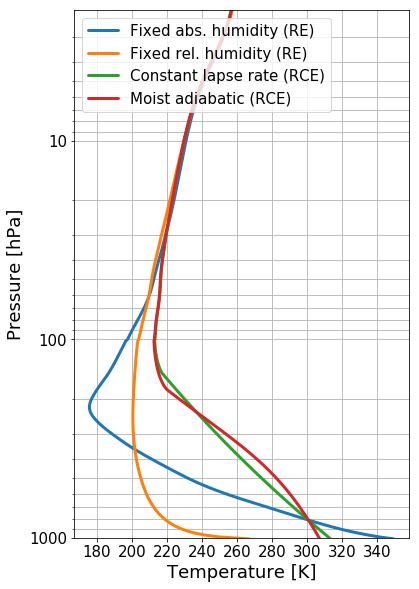

In [1]:
%matplotlib inline
import glob
import os

import matplotlib.pyplot
import typhon
from netCDF4 import Dataset

os.environ['PSRAD_PATH'] = '/scratch/uni/u237/users/lkluft/icon-aes/psrad/'
import conrad
from conrad.utils import extract_metadata

result_dir = 'results/'
season = 'tropical'
plot_dir = 'plots/'

plt.style.use(typhon.plots.styles('typhon'))


def calculate_toa(data):
    """Calculate radiation budget at top of the atmosphere (TOA).
    
    Parameters:
        data (dict): Dictionary containing short- and longwave fluxes.
        
    Returns:
        ndarray: Radiation budget at TOA.
    """
    lw_flxu = data.variables['lw_flxu'][:, -1]
    lw_flxd = data.variables['lw_flxd'][:, -1]
    sw_flxu = data.variables['sw_flxu'][:, -1]
    sw_flxd = data.variables['sw_flxd'][:, -1]
    return ((sw_flxd + lw_flxd) - (sw_flxu + lw_flxu))


legend_labels = {
    'fixedVMR': 'Fixed abs. humidity (RE)',
    'fixedRH': 'Fixed rel. humidity (RE)',
    'convective': 'Constant lapse rate (RCE)',
    'moistconvective': 'Moist adiabatic (RCE)',
}


fig, ax = plt.subplots(figsize=typhon.plots.figsize(6, portrait=True))
for atm in legend_labels.keys():
    inputfile = conrad.utils.get_filepath('tropical-' + atm, 'scale-co2-' + atm, '2')
    print(inputfile)
    dataset = Dataset(inputfile)
    plev = dataset.variables['plev'][:]
    T = dataset.variables['T'][-1, :]
    label = legend_labels[extract_metadata(inputfile).experiment.split('-')[-1]]
    typhon.plots.profile_p_log(plev, T, linewidth=3, label=label)

ax.grid(True, which='both')
ax.legend(loc='upper left')
ax.set_xlabel('Temperature [K]')
ax.set_ylim(bottom=1000e2, top=2.2e2)
# ax.set_xlim(left=180, right=340)
ax.set_xticks(np.arange(180, 341, 20))
fig.savefig(os.path.join(plot_dir, f'{season}_atmosphere_comparison.pdf'))

fixedVMR 0.896805660008
fixedRH 1.79051487686
convective 3.55907430862
moistconvective 2.29812201723


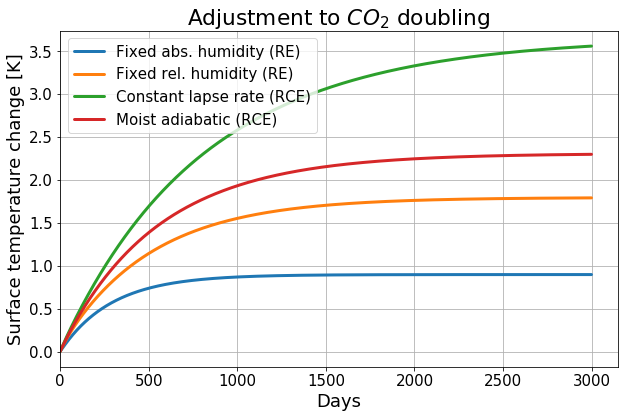

In [2]:
fig, ax = plt.subplots()
for atm in legend_labels.keys():
    inputfile = conrad.utils.get_filepath('tropical-' + atm, 'scale-co2-' + atm, '2')
    dataset = Dataset(inputfile)
    time = dataset.variables['time'][:] / 24
    T_sfc = dataset.variables['temperature'][:]
    label = legend_labels[extract_metadata(inputfile).experiment.split('-')[-1]]
    ax.plot(time, T_sfc - T_sfc[0], linewidth=3, label=label)
    print(atm, T_sfc[-1] - T_sfc[0])

ax.set_title(f'Adjustment to $CO_2$ doubling')
ax.grid(True)
ax.legend(loc='upper left')
ax.set_ylabel('Surface temperature change [K]')
ax.set_xlim(left=0)
ax.set_xlabel('Days')
fig.savefig(os.path.join(plot_dir, f'{season}_t_surface_comparison.pdf'))

AttributeError: 'NoneType' object has no attribute 'get_label'

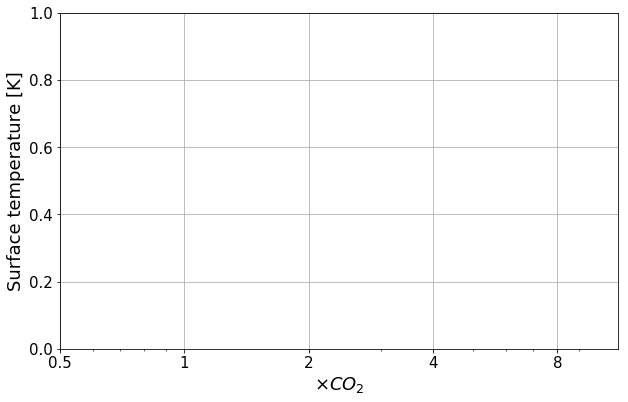

In [4]:
co2_factors = [0.5, 1, 2, 4, 8]
lines = 4 * [None]

fig, ax = plt.subplots()
ax.set_prop_cycle(marker=['^', '>', 'v', '<'])
for co2 in co2_factors:
    for n, inputfile in enumerate(glob.glob(f'{result_dir}/{season}_*_{co2}.nc')):
        print(inputfile)
        dataset = Dataset(inputfile)
        T_sfc = dataset.variables['temperature'][-1]
        lines[n], = ax.plot(
            co2, T_sfc,
            color=f'C{n}',
            markersize=15,
            label=legend_labels[extract_metadata(inputfile).experiment.split('-')[-1]],
            linestyle='none',
        )

ax.grid(True)
ax.set_xscale('log')
ax.set_xticks([0.5, 1, 2, 4, 8])
ax.set_xticklabels([0.5, 1, 2, 4, 8])
ax.set_xlabel(r'$\times CO_2$')
ax.set_ylabel('Surface temperature [K]')
ax.legend(lines, [l.get_label() for l in lines], loc='center left')
fig.savefig(os.path.join(plot_dir, f'{season}_sensitivity_comparison.pdf'))

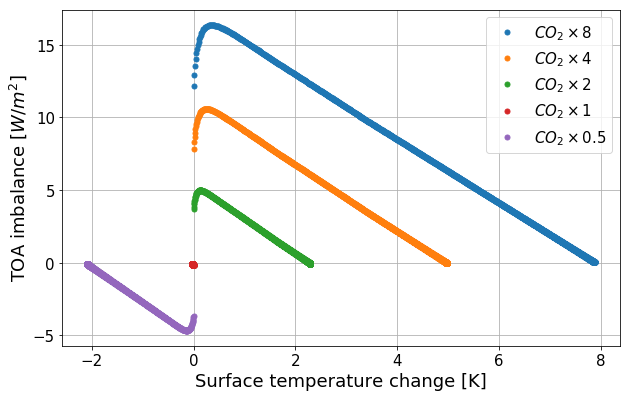

In [9]:
season = 'tropical-moistconvective'
experiment = 'scale-co2-moistconvective'
co2_factors = sorted([0.5, 1, 2, 4, 8], key=float, reverse=True)
# co2_factors = sorted(
#     [extract_metadata(f).scale
#      for f in glob.iglob(f'{result_dir}/{season}_{experiment}_*.nc')],
#     key=float,
# )
nth = 1

fig, ax = plt.subplots()
colors = ['C4', 'C5', 'C6', 'C8', 'C9']
for n, co2 in enumerate(co2_factors):
    inputfile = conrad.utils.get_filepath('tropical-' + atm, 'scale-co2-' + atm, co2)
    dataset = Dataset(inputfile)
    T_sfc = dataset.variables['temperature']
    toa = calculate_toa(dataset)
    ax.plot(
        T_sfc[1::nth] - T_sfc[1], toa[1::nth],
        label=rf'$CO_2 \times {co2}$',
        marker='.',
        # color=colors[n],
        linestyle='none',
        rasterized=True,
    )

ax.grid(True)
ax.set_xlabel('Surface temperature change [K]')
# ax.set_xlim(-5, 15)
ax.set_ylabel('TOA imbalance [$W/m^2$]')
# ax.set_ylim(-5, 20)
ax.legend(bbox_to_anchor=(1, 1), ncol=1)  # , fontsize='xx-small')
# ax.set_title(legend_labels[extract_metadata(inputfile).experiment.split('-')[-1]])
# fig.savefig(os.path.join(plot_dir, f'{season}_{experiment}_gregory.pdf'), dpi=300)
fig.savefig(os.path.join(plot_dir, f'gregory_presentation.pdf'), dpi=600)

In [ ]:
season = 'tropical-moistconvective'
experiment = 'scale-co2-moistconvective'
co2_factors = [0.5, 2, 4, 8]

h_ref = Dataset(f'{result_dir}/{season}_{experiment}_1.nc').variables['z'][-1]
    
fig, ax = plt.subplots(figsize=(6, 6))
for co2 in co2_factors:
    inputfile = f'{result_dir}/{season}_{experiment}_{co2}.nc'
    dataset = Dataset(inputfile)
    
    plev = dataset.variables['plev']
    height = dataset.variables['z'][-1, :]
    
    ax.axvline(0, linestyle='dotted', color='lightgrey', lw=3, zorder=-1)
    typhon.plots.profile_p_log(
        plev[:-1], 100 * (height[:-1] - h_ref[:-1]) / h_ref[:-1],
        linewidth=3,
        label=rf'$CO_2 \times {co2}$',
    )
    
ax.legend()
ax.grid(True)
ax.set_xlabel('Change in layer thickness [%]')
ax.set_xlim(-10, 5)
ax.set_title(legend_labels[extract_metadata(inputfile).experiment.split('-')[-1]])
fig.savefig(os.path.join(plot_dir, f'{season}_{experiment}_plev_height.pdf'))

In [ ]:
import copy
from matplotlib.ticker import ScalarFormatter, NullFormatter


season = 'tropical-moistconvective'
experiment = 'scale-co2-moistconvective'
co2_factors = [2, 4, 8, 16]

fig, ax = plt.subplots()
for i, co2 in enumerate(co2_factors):
    inputfile = f'{result_dir}/{season}_{experiment}_{co2}.nc'
    dataset = Dataset(inputfile)
    
    # Calculate radiation imbalance at top of atmosphere.
    toa = calculate_toa(dataset)[1:]
    T = dataset.variables['temperature'][1:]
    T_change = T - T[0]
    
    F_inst = toa[0]  # instantaneous forcing
    eff_index = np.argmax(np.abs(toa))  # effective forcing
    F_eff = toa[eff_index]
    F_gregory = np.polyfit(T_change[eff_index:], toa[eff_index:], 1)[1]
    
    l1, = ax.plot(co2, F_inst, label=rf'Instantaneous', marker='o', color=f'C{i}', linestyle='none')
    l2, = ax.plot(co2, F_eff, label='Effective', marker='x',  color=f'C{i}', linestyle='none')
    l3, = ax.plot(co2, F_gregory, label='Gregory', marker='*',  color=f'C{i}', linestyle='none')
handles = [copy.copy(l) for l in [l1, l2, l3]]
for handle in handles:
    handle.set_color('black')
ax.set_title(legend_labels[extract_metadata(inputfile).experiment.split('-')[-1]])
ax.grid(True)
ax.set_ylim(0, 25)
ax.set_ylabel('TOA imbalance [W/m$^2$]')
ax.set_xlabel(r'$\times CO_2$')
ax.set_xscale('log')
ax.set_xticks(co2_factors)
ax.xaxis.set_minor_formatter(NullFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.legend(handles=handles, loc='upper left')
fig.savefig(os.path.join(plot_dir, 'gregory_forcings.pdf'))

fig_dummy, ax_dummy = plt.subplots()
fig, ax = plt.subplots()
for i, co2 in enumerate(co2_factors):
    inputfile = f'{result_dir}/{season}_{experiment}_{co2}.nc'
    dataset = Dataset(inputfile)
    
    # Calculate radiation imbalance at top of atmosphere.
    toa = calculate_toa(dataset)[1:]
    T = dataset.variables['temperature'][1:]
    
    s_true, F_true = conrad.utils.equilibrium_sensitivity(T, toa)
    s_gregory, F_gregory = conrad.plots.gregory_plot(T, toa, ax=ax_dummy)
    
    l1, = ax.plot(co2, s_true, label=rf'True', marker='o', color=f'C{i}', linestyle='none')
    l2, = ax.plot(co2, s_gregory, label='Gregory', marker='*',  color=f'C{i}', linestyle='none')
    l3, = ax.plot(co2, s_true - s_gregory, label='Difference', marker='x',  color=f'C{i}', linestyle='none')
plt.close(fig_dummy)
handles = [copy.copy(l) for l in [l1, l2, l3]]
for handle in handles:
    handle.set_color('black')
ax.set_title(legend_labels[extract_metadata(inputfile).experiment.split('-')[-1]])
ax.grid(True)
ax.set_ylabel('Climate sensitivity [K/(W/m$^2)$]')
ax.set_xlabel(r'$\times CO_2$')
ax.set_xscale('log')
ax.set_xticks(co2_factors)
ax.xaxis.set_minor_formatter(NullFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.legend(handles=handles, loc='upper left')
fig.savefig(os.path.join(plot_dir, 'gregory_sensitivity.pdf'))